In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("../../Data/otto-group-product-classification-challenge/train.csv")
data

In [ ]:
data.shape

In [ ]:
data.describe()

In [ ]:
# 图形可视化，查看数据分布
import seaborn as sns

sns.countplot(data.target)

plt.show()

    由上图可知，该数据类别不平衡，需要进行处理
              数据已经进行脱敏，不再需要进行特殊处理

2.数据基本处理

In [ ]:
# 2.1 截取部分数据
new_one = data[:10000]
new_one.shape

In [ ]:
# 图形可视化，查看数据分布
import seaborn as sns

sns.countplot(new_one.target)

plt.show()

    使用上面方式获取数据不可行，数据特征被裁剪，可能会造成较大误差
    由于样本数量非常多，可以使用随机欠采样获取样本的数据

In [ ]:
# 2.1随机欠采样获取数据
# （1）确定目标值、特征值
x = data.drop(["id", "target"], axis=1)
y = data["target"]

In [ ]:
y

In [ ]:
x

In [ ]:
# （2）欠采样获取数据
from imblearn.under_sampling import RandomUnderSampler
rus =RandomUnderSampler(random_state=0)

x_resampled, y_resampled = rus.fit_resample(x, y)

In [ ]:
x_resampled

In [ ]:
y_resampled

In [ ]:
# 图形可视化，查看数据分布
import seaborn as sns

sns.countplot(y_resampled)

plt.show()

In [ ]:
# （3）标签值转换为数字
y_resampled.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_resampled = le.fit_transform(y_resampled)
y_resampled

In [ ]:
# 分割数据
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_resampled,
    y_resampled,
    random_state=22,
    train_size=0.8
)

In [ ]:
x_train.shape,y_resampled.shape

3.模型训练

In [53]:
# 3.1.基本模型训练
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(x_train, y_train)

RandomForestClassifier()

In [54]:
y_pre = rf.predict(x_test)
y_pre

array([5, 7, 6, ..., 1, 1, 2])

In [55]:
rf.score(x_test, y_test)

0.7921105672329398

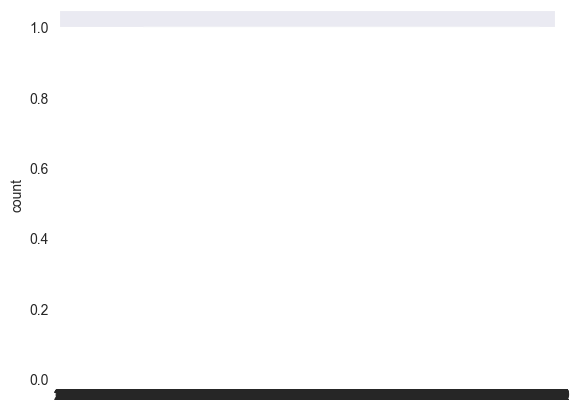

In [56]:
# 预测结果图形可视化
import seaborn as sns

sns.countplot(y_pre)

plt.show()

In [57]:
# logloss模型评估
from sklearn.metrics import log_loss
log_loss(y_test, y_pre, normalize=True)

ValueError: y_true and y_pred contain different number of classes 9, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 1 2 3 4 5 6 7 8]

In [58]:
y_test,y_pre

(array([5, 7, 2, ..., 2, 2, 3]), array([5, 7, 6, ..., 1, 1, 2]))

    上面报错的原因；logloss使用过程中，必须要求将输出用one-hot表示，
    需要将这个多类别问题的输出结果通过OneHotEncoder修改如下

In [59]:
# 将类别问题转换为one-hot形式
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder()

y_test1 = one_hot.fit_transform(y_test.reshape(-1,1))
y_pre1 = one_hot.fit_transform(y_pre.reshape(-1,1))

In [60]:
y_test1, y_pre1

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 3473 stored elements and shape (3473, 9)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 3473 stored elements and shape (3473, 9)>)

In [62]:
log_loss(y_test1.toarray(), y_pre1.toarray(), normalize=True)

7.493094657916091

In [63]:
# 改变预测值的输出模式，让输出结果为百分占比，降低logloss值
y_pre_probs = rf.predict_proba(x_test)
y_pre_probs

array([[0.03, 0.  , 0.  , ..., 0.04, 0.02, 0.  ],
       [0.05, 0.  , 0.  , ..., 0.  , 0.9 , 0.05],
       [0.16, 0.16, 0.18, ..., 0.19, 0.06, 0.13],
       ...,
       [0.01, 0.63, 0.22, ..., 0.  , 0.  , 0.  ],
       [0.05, 0.37, 0.27, ..., 0.02, 0.03, 0.04],
       [0.01, 0.16, 0.4 , ..., 0.04, 0.  , 0.  ]])

In [66]:
log_loss(y_test1.toarray(), y_pre_probs, normalize=True)

0.7415134294051973

## 模型调优
n_estimator,
max_feature,
max_depth,
min_samples_leaf,

### 确定最优的n_estimators

In [67]:
# 确定n_estimator的取值范围
tuned_parameters = range(10, 200, 10)
# 创建添加accuracy的一个numpy
accuracy_t = np.zeros(len(tuned_parameters))
# 创建添加error的一个numpy
error_t = np.zeros(len(tuned_parameters))
# 调优过程
for j, one_parameter in enumerate(tuned_parameters):
    rf2 = RandomForestClassifier(n_estimators=one_parameter, 
                                 max_depth=10, 
                                 max_features=10, 
                                 min_samples_leaf=10, 
                                 oob_score=True, 
                                 random_state=0, 
                                 n_jobs=-1)
    rf2.fit(x_train,y_train)
    # 输出accuracy
    accuracy_t[j] = rf2.oob_score_
    
    # 输出log_loss
    y_pre = rf2.predict_proba(x_test)
    error_t = log_loss(y_test, y_pre, normalize=True)
    
    print(error_t)

D:\study\AI\Machine_learning\ML_Study\venv\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
D:\study\AI\Machine_learning\ML_Study\venv\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


1.129549554696466
1.11749139512565
1.1234900377869896
1.1193922248636234
1.1157271916377165
1.1147610148129226
1.1130689698930987
1.114067439827195
1.1159032646381541
1.1123965501612858
1.1102996988781073
1.110913223575563
1.1104415668382757
1.109670489227218
1.1085140065780315
1.107246699809414
1.1083483834137875
1.1083607861698932
1.1083637121363583


ValueError: x and y must have same first dimension, but have shapes (19,) and (1,)

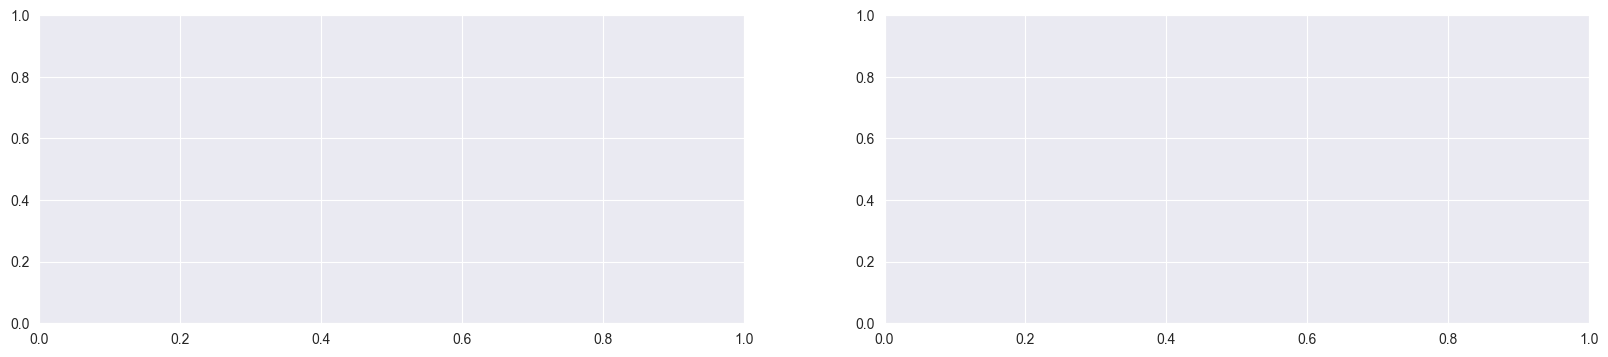

In [69]:
# 优化结果过程可视化---确定超参数
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4), dpi=100)

axes[0].plot(tuned_parameters, error_t)
axes[0].set_xlabel("n_estimators")
axes[0].set_ylabel("error_t")
axes[0].grid(True)


axes[1].plot(tuned_parameters, accuracy_t)
axes[1].set_xlabel("n_estimators")
axes[1].set_ylabel("accuracy_t")
axes[1].grid(True)

plt.show()

    经过图像展示，最后确定n_estimators=175时，训练结果较好